# Lesson 6: Tricks of the trade

In this course we will cover:
1. Learning rate scheduler/Dynamic learning rate
2. Dropout (macht validation besser)
3. Risidual connections (alles)
4. batch normalisation (CNN), layer normalisation (Transformer) —> alle Arten von normalisation
5. initialisation
6. early stopping
7. Transfer learning
8. Augmentation



We will work with the same data set and model as in notebook 4 and go through some regularizations and ... methods.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# Define device:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")  
elif  torch.mtia.is_available():
    device = torch.device("mtia")
else:
    device = torch.device("cpu")

In [2]:
# Creating the data
def generate_waveform(wave_type, length, fs):
    t = np.linspace(0, 1, length, endpoint=False)
    freq = np.random.uniform(1, 10)      # random frequency 1-10Hz
    amp = np.random.uniform(0.5, 1.5)    # random amplitude
    phi = np.random.uniform(0, 2*np.pi)  # random phases

    if wave_type == 'sine':
        y = amp * np.sin(2 * np.pi * freq * t + phi)
    elif wave_type == 'triangle':
        y = amp * signal.sawtooth(2 * np.pi * freq * t + phi, 0.5)
    elif wave_type == 'square':
        y = amp * signal.square(2 * np.pi * freq * t + phi)
    else:
        raise ValueError("Unknown wave type")
    
    # optional noise
    noise = np.random.normal(0, 0.05, length)
    y += noise
    return y

# Parameters
num_samples = 200      # samples per waveform type
length = 128           # number of points per waveform
fs = 128               # sampling frequency

# Generate dataset in memory
wave_types = ['sine', 'triangle', 'square']
X = []
y = []

for idx, wave in enumerate(wave_types):
    for _ in range(num_samples):
        waveform = generate_waveform(wave, length, fs)
        X.append(waveform)
        y.append(idx)  # class label: 0=sine, 1=triangle, 2=square


# Convert to numpy arrays
X = np.array(X)  
y = np.array(y)  

In [3]:
# Class to create our data set with torch.utils.data.Dataset
class WaveformDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # add channel dimension
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
dataset = WaveformDataset(X, y)

train_size = int(0.6 * len(dataset))
valid_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# Our CNN model for waveform classification
class Waveform_Classification_CNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5,  stride=2)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(224, 64) 
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
def train_epoch(model, train_loader,  criterion, optimizer, lr_scheduler, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        
        loss.backward()

        optimizer.step()
        
        # Accumulate loss and accuracy
        total_loss += loss.item()
        
        # Calculate accuracy (no need to reshape for classification)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Step scheduler after epoch if provided
    if lr_scheduler:
        lr_scheduler.step()
       

    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total

    return avg_loss, accuracy

def validate(model, valid_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0  

    with torch.no_grad():
        for inputs, labels in valid_loader:  
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass only (no gradient computation)
            outputs = model(inputs)
            
            # Reshape for loss computation
            outputs_flat = outputs.reshape(-1, outputs. size(-1))
            labels_flat = labels.reshape(-1)
            
            # Compute loss
            loss = criterion(outputs_flat, labels_flat)
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = outputs_flat.max(1)
            total += labels_flat.size(0)
            correct += predicted.eq(labels_flat).sum().item()
        
        avg_loss = total_loss / len(valid_loader)
        accuracy = 100. * correct / total
    
    return avg_loss, accuracy

In [6]:
# Training loop 
def train_model(model, train_loader, valid_loader, criterion, optimizer, lr_scheduler=None, early_stopping=None, n_epochs=15, device='cpu'):
    print("Starting training...")
    
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    
    for epoch in range(n_epochs):
        # Train for one epoch
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, lr_scheduler, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Evaluate on validation set
        val_loss, val_acc = validate(model, valid_loader, criterion, device)
        valid_losses.append(val_loss)
        valid_accuracies.append(val_acc)
        
        # Print progress every 100 epochs or on first/last epoch
        if n_epochs <= 30:
            if epoch % 5 == 0 or epoch == n_epochs - 1:
                print(f'Epoch [{epoch+1}/{n_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
                if lr_scheduler:
                     print(f'Learning Rate after epoch: {lr_scheduler.get_last_lr()[0]:.6f}')   
        elif n_epochs > 30:
            if epoch % 10 == 0 or epoch == n_epochs - 1:
                print(f'Epoch [{epoch+1}/{n_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            
        if early_stopping:
            if early_stopping.step(val_loss) == True:
                print("Early stopping triggered")
                n_epochs = epoch + 1
                model.load_state_dict(early_stopping.best_weights)  
                break


    print('-' * 50)

    print("Training completed!")

    plt.figure(figsize=(10, 4))
    plt.plot(range(n_epochs), train_losses, label='Train Loss')
    plt.plot(range(n_epochs), valid_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return train_losses, valid_losses, train_accuracies, valid_accuracies

First we train the model without any regularization.

Starting training...
Epoch [1/15] - Train Loss: 1.0752, Train Acc: 38.33% | Val Loss: 0.9066, Val Acc: 55.00%
Epoch [6/15] - Train Loss: 0.4509, Train Acc: 76.94% | Val Loss: 0.5044, Val Acc: 67.50%
Epoch [11/15] - Train Loss: 0.3753, Train Acc: 82.78% | Val Loss: 0.4989, Val Acc: 72.50%
Epoch [15/15] - Train Loss: 0.3168, Train Acc: 83.06% | Val Loss: 0.4451, Val Acc: 73.33%
--------------------------------------------------
Training completed!


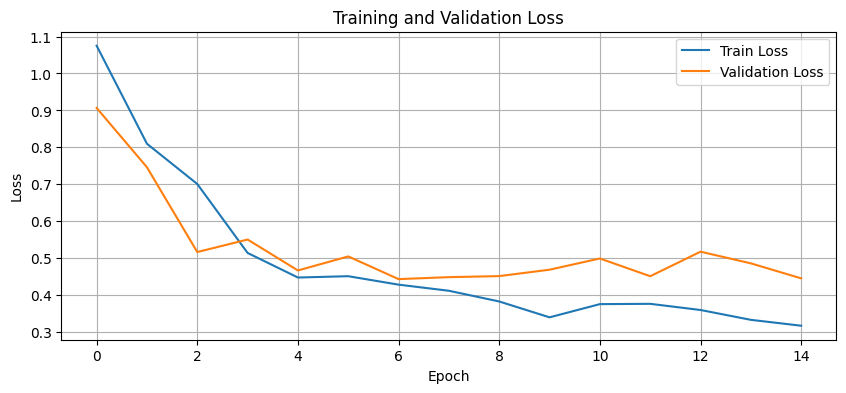

In [7]:
n_epochs = 15

model = Waveform_Classification_CNN(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model with scheduler enabled
train_losses, valid_losses, train_accs, valid_accs = train_model(
    model=model, 
    train_loader=train_loader, 
    valid_loader=valid_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    n_epochs=n_epochs, 
    device=device
)


In [8]:
model.eval()
all_preds = []
all_labels = []
all_inputs = []
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_inputs.extend(inputs.cpu().numpy()) 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")

Accuracy: 73.33%


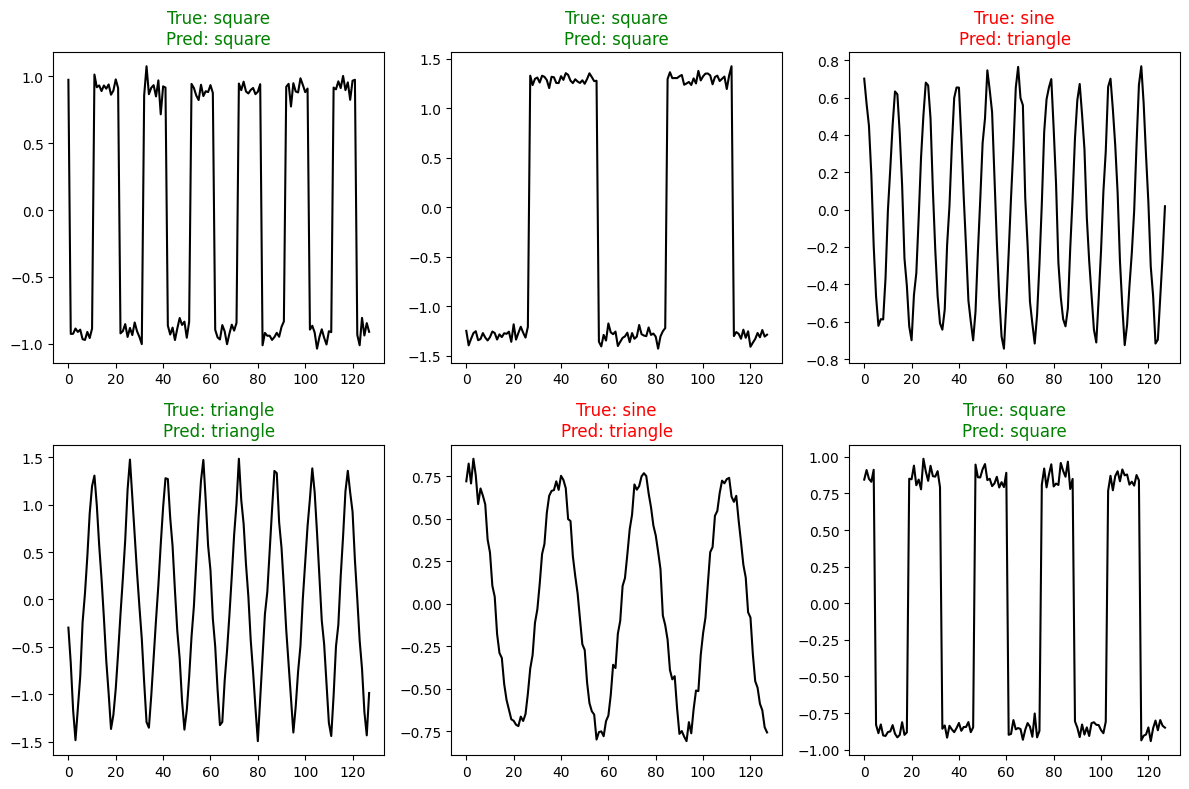

In [9]:
wave_types = ['sine', 'triangle', 'square']
n_examples = 6
idxs = np.random.choice(len(all_inputs), n_examples, replace=False)

plt.figure(figsize=(12, 8))
for i, idx in enumerate(idxs):
    plt.subplot(2, 3, i+1)
    plt.plot(all_inputs[idx][0], color='black')
    plt.title(f"True: {wave_types[all_labels[idx]]}\nPred: {wave_types[all_preds[idx]]}",
              color="green" if all_labels[idx] == all_preds[idx] else "red")
    plt.tight_layout()
plt.show()

## Using a Scheduler or Dynamic Learning Rate

One way to improve the performance of the model is by using a scheduler for the learning rate or use a dynamic learning rate. 

### What is a Learning Rate Scheduler?

A learning rate scheduler is a technique that adjusts the learning rate during training according to a predefined strategy. Instead of keeping the learning rate constant throughout the entire training process, the scheduler modifies it at specific intervals (e.g., per epoch or per batch).

Common scheduling strategies include:
- **Step Decay**: Reduces the learning rate by a factor every few epochs
- **Exponential Decay**: Gradually decreases the learning rate exponentially
- **Cosine Annealing**: Varies the learning rate following a cosine curve
- **ReduceLROnPlateau**: Reduces the learning rate when a metric stops improving

### Why Does It Make Training More Effective? 

1. **Better Convergence**: Starting with a higher learning rate allows the model to make large steps toward the optimal solution early in training.  As training progresses, a lower learning rate helps fine-tune the parameters and converge to a better minimum.

2. **Escape Local Minima**: A dynamic learning rate can help the model escape shallow local minima in the early stages while settling into deeper, better minima as the rate decreases.

3. **Prevents Overshooting**: A constant high learning rate might cause the optimizer to overshoot the optimal point. Reducing it over time ensures more precise updates near convergence.

4. **Improved Generalization**: Gradually lowering the learning rate can lead to flatter minima, which often generalize better to unseen data. 

5. **Faster Training**: By adapting the learning rate to the training dynamics, schedulers can achieve better results in fewer epochs compared to a fixed learning rate.


Starting training...
Epoch [1/15] - Train Loss: 1.0406, Train Acc: 41.11% | Val Loss: 0.8698, Val Acc: 57.50%
Learning Rate after epoch: 0.010000
Epoch [6/15] - Train Loss: 0.3783, Train Acc: 80.83% | Val Loss: 0.5024, Val Acc: 67.50%
Learning Rate after epoch: 0.007000
Epoch [11/15] - Train Loss: 0.2894, Train Acc: 85.28% | Val Loss: 0.4702, Val Acc: 71.67%
Learning Rate after epoch: 0.004900
Epoch [15/15] - Train Loss: 0.3097, Train Acc: 83.61% | Val Loss: 0.4215, Val Acc: 75.83%
Learning Rate after epoch: 0.003430
--------------------------------------------------
Training completed!


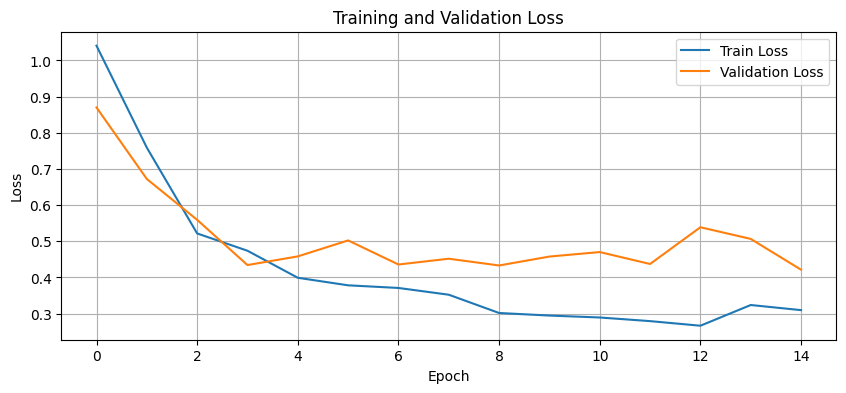

In [10]:
n_epochs = 15

model = Waveform_Classification_CNN(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

# Train the model with scheduler enabled
train_losses, valid_losses, train_accs, valid_accs = train_model(
    model=model, 
    train_loader=train_loader, 
    valid_loader=valid_loader, 
    optimizer=optimizer, 
    lr_scheduler=scheduler, 
    criterion=criterion, 

    n_epochs=n_epochs, 

    device=device
)

## Batch normalization

One powerful technique to improve training stability and speed up convergence is by using batch normalization.  Batch normalization has become a standard component in modern deep neural networks. 

Batch normalization is a technique that normalizes the inputs of each layer by adjusting and scaling the activations.  For each mini-batch during training, it:

1. Calculates the mean and variance of the activations
2. Normalizes the activations using these statistics
3. Scales and shifts the normalized values using learnable parameters (γ and β)

The normalization formula for a batch:
```
x_norm = (x - μ_batch) / √(σ²_batch + ε)
output = γ * x_norm + β
```

Where:
- **μ_batch**: Mean of the batch
- **σ²_batch**: Variance of the batch
- **ε**: Small constant for numerical stability (e.g., 1e-5)
- **γ, β**: Learnable parameters for scale and shift

Typically the normalization is placed **after** the linear/convolutional layer and **before** the activation function:
   ```
   Conv/Linear → BatchNorm → Activation (ReLU)
   ```
It works best with reasonably sized batches (≥16).  Very small batches can cause instability. 


### Why Does It Make Training More Effective?

1. **Faster Training**: By normalizing activations, batch normalization allows for higher learning rates without the risk of divergence.  This can speed up training by 2-10x in some cases.

2. **Reduces Internal Covariate Shift**: As the network learns, the distribution of inputs to each layer changes. Batch normalization stabilizes these distributions, making training more stable and predictable.

3. **Acts as Regularization**: Batch normalization introduces a slight noise (because statistics are computed per batch), which has a mild regularization effect similar to dropout.  This can reduce the need for other regularization techniques.

4. **Reduces Sensitivity to Initialization**: Networks with batch normalization are less sensitive to the initial weights, making training more robust and reproducible.

5. **Helps Gradient Flow**: By keeping activations in a reasonable range, batch normalization prevents vanishing or exploding gradients, allowing gradients to flow more effectively through deep networks.

6. **Enables Deeper Networks**: The stabilizing effect of batch normalization makes it possible to train much deeper networks that would otherwise be difficult to optimize.


In [11]:
# Our CNN model for waveform classification with risidual connections
class CNN_with_batch_normalization(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(16, momentum=0.01)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm1d(32, momentum=0.01)
        self.pool = nn.MaxPool1d(2)
        
        self.fc1 = nn.Linear(224, 64) 
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = F.relu(x)
        x = self.pool(x)

        x = self.bn2(self.conv2(x))
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(x. size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
  
        
        return x

Starting training...
Epoch [1/50] - Train Loss: 1.0871, Train Acc: 37.50% | Val Loss: 1.0503, Val Acc: 37.50%
Epoch [11/50] - Train Loss: 0.5438, Train Acc: 78.06% | Val Loss: 0.5809, Val Acc: 66.67%
Epoch [21/50] - Train Loss: 0.3376, Train Acc: 84.17% | Val Loss: 0.4927, Val Acc: 73.33%
Epoch [31/50] - Train Loss: 0.3004, Train Acc: 84.72% | Val Loss: 0.5060, Val Acc: 70.00%
Epoch [41/50] - Train Loss: 0.2066, Train Acc: 92.22% | Val Loss: 0.5071, Val Acc: 74.17%
Epoch [50/50] - Train Loss: 0.1732, Train Acc: 91.94% | Val Loss: 0.5517, Val Acc: 74.17%
--------------------------------------------------
Training completed!


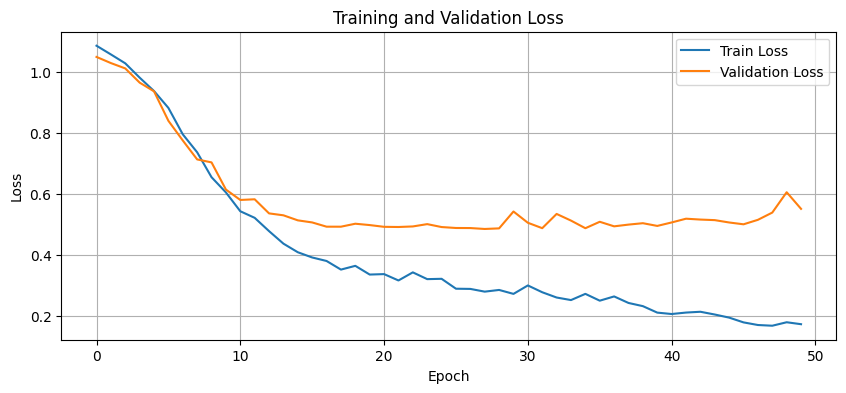

In [12]:
n_epochs = 50

model = Waveform_Classification_CNN(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0008)
scheduler = None

# Train the model with residual connections
train_losses, valid_losses, train_accs, valid_accs = train_model(
    model=model, 
    train_loader=train_loader, 
    valid_loader=valid_loader, 
    optimizer=optimizer, 
    lr_scheduler=scheduler, 
    criterion=criterion, 
    n_epochs=n_epochs, 
    device=device
)

Starting training...
Epoch [1/50] - Train Loss: 1.0102, Train Acc: 44.44% | Val Loss: 1.0606, Val Acc: 37.50%
Epoch [11/50] - Train Loss: 0.3234, Train Acc: 84.17% | Val Loss: 1.3291, Val Acc: 31.67%
Epoch [21/50] - Train Loss: 0.1890, Train Acc: 94.44% | Val Loss: 1.1591, Val Acc: 48.33%
Epoch [31/50] - Train Loss: 0.0925, Train Acc: 98.61% | Val Loss: 0.4106, Val Acc: 77.50%
Epoch [41/50] - Train Loss: 0.0372, Train Acc: 99.44% | Val Loss: 0.3707, Val Acc: 82.50%
Epoch [50/50] - Train Loss: 0.0353, Train Acc: 98.89% | Val Loss: 0.3788, Val Acc: 86.67%
--------------------------------------------------
Training completed!


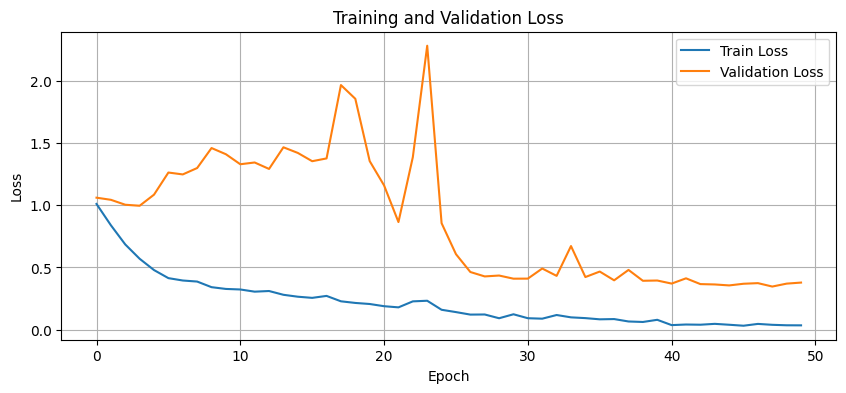

In [13]:
n_epochs = 50

model = CNN_with_batch_normalization(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0008)
scheduler = None

# Train the model with residual connections
train_losses, valid_losses, train_accs, valid_accs = train_model(
    model=model, 
    train_loader=train_loader, 
    valid_loader=valid_loader, 
    optimizer=optimizer, 
    lr_scheduler=scheduler, 
    criterion=criterion, 
    n_epochs=n_epochs, 
    device=device
)

## Using Residual Connections

One powerful architectural technique to improve deep neural network training is by using residual connections (also known as skip connections). 

Residual connections create shortcuts that allow the input of a layer (or block of layers) to bypass those layers and be added directly to the output.  Instead of learning a direct mapping H(x), the layers learn a residual mapping F(x), and the final output becomes F(x) + x. The input and output dimensions must match for the addition operation.  If they don't, use a projection (typically a 1x1 convolution) on the skip connection. Typically, the activation function (ReLU) is applied **after** the addition of the residual connection. Residual connections combine well with batch normalization, dropout, and other regularization techniques. 

This concept was introduced in ResNet (Residual Networks) and has become a fundamental building block in modern deep learning architectures.

### Why Do They Make Training More Effective?

1. **Solves Vanishing Gradient Problem**: In very deep networks, gradients can become extremely small during backpropagation, making it difficult for early layers to learn.  Residual connections provide direct gradient pathways, allowing gradients to flow backward through the network more easily.

2. **Enables Deeper Networks**: Before residual connections, making networks deeper often degraded performance due to optimization difficulties. Residual connections make it possible to train networks with hundreds or even thousands of layers effectively.

3. **Easier Optimization**: Learning the residual (the difference between input and desired output) is often easier than learning the complete transformation.  If the optimal function is close to an identity mapping, the network can simply learn to make F(x) ≈ 0.

4. **Identity Mapping**: In the worst case, if additional layers aren't helpful, the network can learn to pass the input through unchanged (identity function) by setting the residual to zero.  This ensures deeper models perform at least as well as shallower ones.

5. **Feature Reuse**: Skip connections allow the network to reuse features from earlier layers, combining low-level and high-level features for better representations.

6. **Faster Convergence**: Networks with residual connections often converge faster during training because the gradient signal is stronger and more stable.

In [14]:
# Our CNN model for waveform classification with risidual connections
class CNN_with_Residual_Connections(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(16)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool = nn.MaxPool1d(2)

        self.conv_1x1 = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5, stride=2),  # Match conv1
            nn.MaxPool1d(2),                             # Match first pool
            nn.Conv1d(16, 32, kernel_size=5, stride=2),  # Match conv2
            nn.MaxPool1d(2)                              # Match second pool
        )
        
        self.fc_projection = nn.Linear(224, 64)
        self.fc1 = nn.Linear(224, 64) 
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        residual  = x
        x = self.bn1(self.conv1(x))
        x = F.relu(x)
        x = self.pool(x)

        x = self.bn2(self.conv2(x))
        x = F.relu(x)
        x = self.pool(x)

        residual = self.conv_1x1(residual)  # Shape: [batch, 32, matching_length]
        residual = self.pool(self.pool(residual)) 

        x = x + residual
        x = F.relu(x) 
        
        x = x.view(x. size(0), -1)  # flatten
   
        residual_fc = self.fc_projection(x)
        x = F.relu(self.fc1(x))
        x = x + residual_fc 
        x = F.relu(x)  

        x = self.fc2(x)
  
        

        return x

Starting training...
Epoch [1/50] - Train Loss: 1.0231, Train Acc: 45.00% | Val Loss: 1.0517, Val Acc: 37.50%
Epoch [11/50] - Train Loss: 0.3428, Train Acc: 87.50% | Val Loss: 1.3948, Val Acc: 34.17%
Epoch [21/50] - Train Loss: 0.1824, Train Acc: 92.78% | Val Loss: 1.3518, Val Acc: 40.83%
Epoch [31/50] - Train Loss: 0.0990, Train Acc: 98.33% | Val Loss: 0.6786, Val Acc: 67.50%
Epoch [41/50] - Train Loss: 0.1364, Train Acc: 94.72% | Val Loss: 0.4394, Val Acc: 79.17%
Epoch [50/50] - Train Loss: 0.0785, Train Acc: 97.78% | Val Loss: 0.4388, Val Acc: 80.83%
--------------------------------------------------
Training completed!


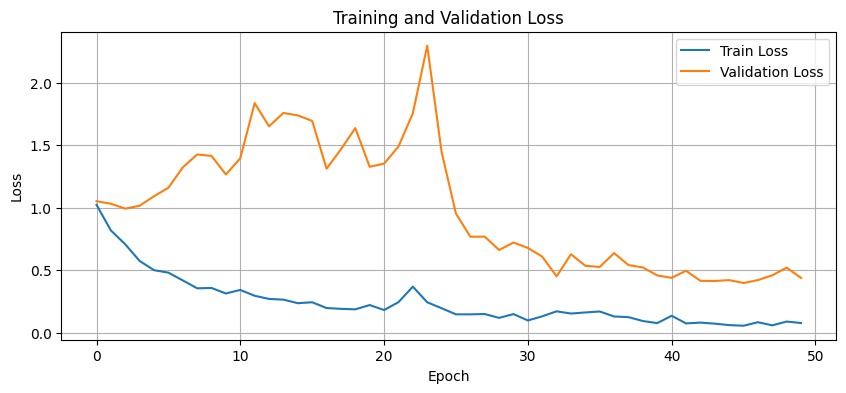

In [15]:
n_epochs = 50

model = CNN_with_batch_normalization(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0008)
scheduler = None

# Train the model with residual connections
train_losses, valid_losses, train_accs, valid_accs = train_model(
    model=model, 
    train_loader=train_loader, 
    valid_loader=valid_loader, 
    optimizer=optimizer, 
    lr_scheduler=scheduler, 
    criterion=criterion, 
    n_epochs=n_epochs, 
    device=device
)

Starting training...
Epoch [1/50] - Train Loss: 1.0523, Train Acc: 43.06% | Val Loss: 1.0189, Val Acc: 45.83%
Epoch [11/50] - Train Loss: 0.2844, Train Acc: 88.33% | Val Loss: 0.4219, Val Acc: 72.50%
Epoch [21/50] - Train Loss: 0.1293, Train Acc: 96.11% | Val Loss: 0.2892, Val Acc: 84.17%
Epoch [31/50] - Train Loss: 0.1593, Train Acc: 95.83% | Val Loss: 0.3079, Val Acc: 86.67%
Epoch [41/50] - Train Loss: 0.0366, Train Acc: 99.44% | Val Loss: 0.2555, Val Acc: 89.17%
Epoch [50/50] - Train Loss: 0.0240, Train Acc: 99.72% | Val Loss: 0.2019, Val Acc: 92.50%
--------------------------------------------------
Training completed!


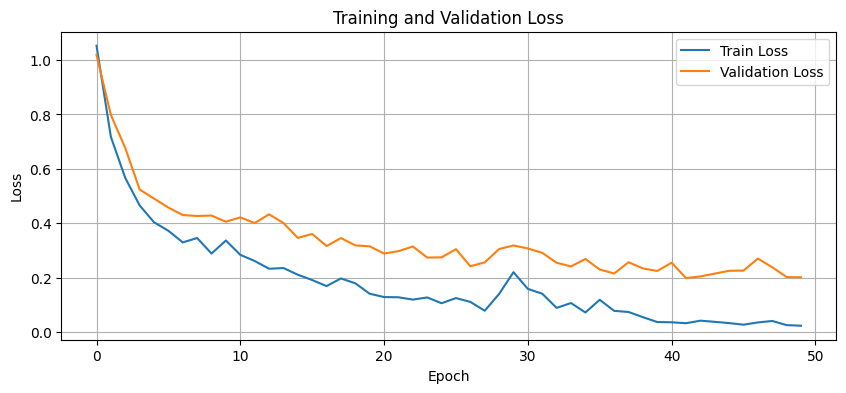

In [16]:
n_epochs = 50

model = CNN_with_Residual_Connections(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0008)
scheduler = None

# Train the model with residual connections
train_losses, valid_losses, train_accs, valid_accs = train_model(
    model=model, 
    train_loader=train_loader, 
    valid_loader=valid_loader, 
    optimizer=optimizer, 
    lr_scheduler=scheduler, 
    criterion=criterion, 
    n_epochs=n_epochs, 
    device=device
)

## Weight Initialization

One often overlooked but important technique for successful training is proper weight initialization. Weight initialization refers to how we set the initial values of the network's parameters before training begins. 

Weight initialization is the process of setting initial values for the weights and biases in a neural network before training starts. Instead of starting with random values from a simple distribution (like uniform random between -1 and 1), we use carefully designed initialization strategies that account for the network's architecture. 

### Common Initialization Strategies

- **Xavier/Glorot Initialization**: Designed for layers with sigmoid or tanh activations.  Scales weights based on the number of input and output neurons.
- **Kaiming/He Initialization**: Designed for layers with ReLU activations. Accounts for the fact that ReLU zeros out half the neurons.
- **Zero Initialization**: Setting all weights to zero, however neurons will all learn identically.
- **Small Random Values**: Simple random initialization with small values (outdated approach).

### Why Does It Matter?

1. **Prevents Vanishing/Exploding Gradients**:  Proper initialization keeps the gradients in a reasonable range during the first few iterations, preventing them from becoming too small (vanishing) or too large (exploding).

2. **Faster Convergence**: With good initialization, the network starts closer to a good solution, reducing the number of epochs needed to reach good performance.

3. **Avoids Symmetry Breaking Issues**: If all weights start with the same value, all neurons in a layer will learn the same features.  Proper initialization breaks this symmetry.

4. **Maintains Signal Variance**: Good initialization ensures that the variance of activations and gradients stays roughly constant across layers, making training more stable.

5. **Activation-Specific**:  Different activation functions (ReLU, tanh, sigmoid) have different properties, and initialization should match the activation being used.

6. **Reduces Sensitivity to Learning Rate**: Proper initialization makes the network less sensitive to the choice of learning rate, making hyperparameter tuning easier.

### PyTorch Default Initialization

PyTorch layers come with default initialization: 
- **Linear layers**: Uniform distribution scaled by layer size
- **Conv layers**: Kaiming uniform initialization
- **BatchNorm**:  Weights=1, Bias=0

While these defaults often work well, custom initialization can improve performance. 

### Best Practices

1. **Match activation function**: Use Kaiming for ReLU, Xavier for tanh/sigmoid
2. **Initialize biases to zero**: Typically safe to start biases at 0
3. **BatchNorm special case**: Always initialize BatchNorm weights to 1 and bias to 0
4. **Consistent initialization**: Use the same strategy throughout the network

Modern practices (Kaiming + ReLU) work well in most cases

### When Weight Initialization Matters Most

**Critical for:**
- Very deep networks (>20 layers)
- Networks without batch normalization
- Recurrent networks (RNNs, LSTMs)
- When training from scratch

**Less critical for:**
- Shallow networks (<10 layers)
- Networks with batch normalization (BatchNorm reduces initialization sensitivity)
- Transfer learning (using pre-trained weights)



In [17]:
import torch.nn.init

# Our CNN model for waveform classification with initialization
class CNN_with_initialization(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, stride=2)
        torch.nn.init.xavier_uniform(self.conv1.weight)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5,  stride=2)
        torch.nn.init.xavier_uniform(self.conv2.weight)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(224, 64) 
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    #### Is this necessary? ####

# Preventing overfitting

Overfitting is a big problem when training a model. We can see that when we train the model for too long, the validation error starts increasing again which suggests that the model is overfitting. There are a few regulations that can be implemented to prevent the overfitting when training.

Starting training...
Epoch [1/100] - Train Loss: 1.0546, Train Acc: 48.06% | Val Loss: 0.8915, Val Acc: 52.50%
Epoch [11/100] - Train Loss: 0.3414, Train Acc: 83.06% | Val Loss: 0.5301, Val Acc: 71.67%
Epoch [21/100] - Train Loss: 0.2327, Train Acc: 90.00% | Val Loss: 0.6884, Val Acc: 79.17%
Epoch [31/100] - Train Loss: 0.1718, Train Acc: 91.39% | Val Loss: 0.6311, Val Acc: 78.33%
Epoch [41/100] - Train Loss: 0.0463, Train Acc: 98.89% | Val Loss: 0.8372, Val Acc: 80.00%
Epoch [51/100] - Train Loss: 0.0227, Train Acc: 99.72% | Val Loss: 1.5513, Val Acc: 70.83%
Epoch [61/100] - Train Loss: 0.0240, Train Acc: 99.72% | Val Loss: 0.8324, Val Acc: 79.17%
Epoch [71/100] - Train Loss: 0.0370, Train Acc: 98.61% | Val Loss: 0.9160, Val Acc: 83.33%
Epoch [81/100] - Train Loss: 0.0022, Train Acc: 100.00% | Val Loss: 1.1778, Val Acc: 80.83%
Epoch [91/100] - Train Loss: 0.0011, Train Acc: 100.00% | Val Loss: 1.2726, Val Acc: 83.33%
Epoch [100/100] - Train Loss: 0.0007, Train Acc: 100.00% | Val Loss:

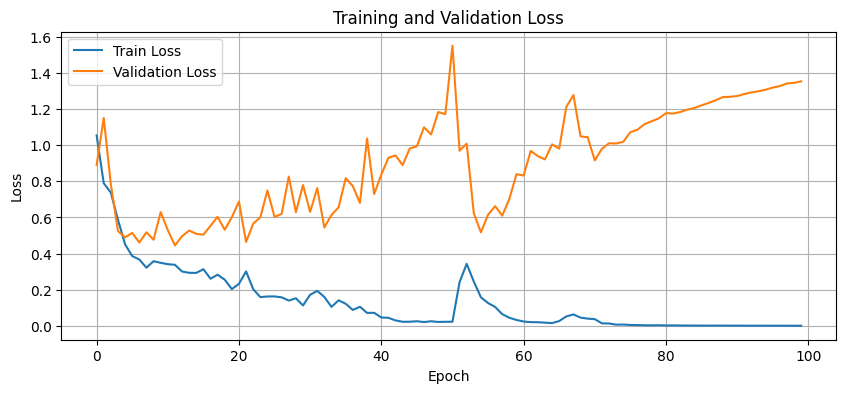

In [18]:
n_epochs = 100


model = Waveform_Classification_CNN(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = None

# Train the model without
train_losses, valid_losses, train_accs, valid_accs = train_model(
    model=model, 
    train_loader=train_loader, 
    valid_loader=valid_loader, 
    optimizer=optimizer, 
    lr_scheduler=scheduler, 
    criterion=criterion, 
    n_epochs=n_epochs, 
    device=device
)

## Dropout

One effective technique to prevent overfitting and improve model generalization is by using dropout during training. 

Dropout is a regularization technique where random neurons are temporarily "dropped" (set to zero) during training with a specified probability. This means that during each training iteration, a different subset of neurons is active, forcing the network to learn more robust features. Dropout is only applied during training. During evaluation/inference, all neurons are active, and their outputs are typically scaled to account for the dropout rate used during training. 

Common dropout rates range from 0.2 to 0.5. Higher rates provide stronger regularization but may hurt learning if too high. For example, with a dropout rate of 0.5, each neuron has a 50% chance of being deactivated during any given training step.

 
### Why Does It Make Training More Effective?

1.  **Prevents Overfitting**: By randomly dropping neurons, dropout prevents the network from relying too heavily on specific neurons or learning complex co-adaptations between neurons that only work on the training data.

2. **Ensemble Effect**: Dropout can be viewed as training an ensemble of multiple sub-networks simultaneously. At inference time, using all neurons approximates averaging the predictions of all these sub-networks, leading to better generalization.

3.  **Forces Redundancy**: Since any neuron can be dropped at any time, the network learns to distribute information across multiple neurons rather than concentrating it in a few.  This creates more robust and redundant representations.

4. **Reduces Co-adaptation**: Without dropout, neurons can develop complex interdependencies that don't generalize well.  Dropout breaks these dependencies, forcing each neuron to learn more independently useful features.

5. **Improves Generalization**: Models trained with dropout typically perform better on unseen data because they learn more general patterns rather than memorizing the training set.


In [19]:
# Our CNN model for waveform classification with dropout
class CNN_with_dropout(nn.Module):
    def __init__(self, num_classes=3, dropout_rate_conv=0.2, dropout_rate_lin=0.5):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, stride=2)
        self.pool = nn.MaxPool1d(2)
        
        # Add dropout layers
        self.dropout_conv = nn.Dropout(dropout_rate_conv)  # Lower dropout for conv layers
        self.dropout_fc = nn.Dropout(dropout_rate_lin)  # Higher dropout for fully connected
        
        self.fc1 = nn.Linear(224, 64) 
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout_conv(x)  # Dropout after first conv block
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout_conv(x)  # Dropout after second conv block
        
        x = x.view(x. size(0), -1)  # flatten
        x = F. relu(self.fc1(x))
        x = self.dropout_fc(x)  # Dropout after first FC layer
        x = self.fc2(x)
        return x

Starting training...
Epoch [1/100] - Train Loss: 1.0464, Train Acc: 39.17% | Val Loss: 0.8823, Val Acc: 60.00%
Epoch [11/100] - Train Loss: 0.3292, Train Acc: 82.50% | Val Loss: 0.5030, Val Acc: 73.33%
Epoch [21/100] - Train Loss: 0.2865, Train Acc: 86.39% | Val Loss: 0.3890, Val Acc: 75.83%
Epoch [31/100] - Train Loss: 0.2117, Train Acc: 88.06% | Val Loss: 0.3028, Val Acc: 84.17%
Epoch [41/100] - Train Loss: 0.2288, Train Acc: 92.22% | Val Loss: 0.6285, Val Acc: 80.83%
Epoch [51/100] - Train Loss: 0.1574, Train Acc: 92.22% | Val Loss: 0.3653, Val Acc: 83.33%
Epoch [61/100] - Train Loss: 0.1980, Train Acc: 91.67% | Val Loss: 0.4126, Val Acc: 85.83%
Epoch [71/100] - Train Loss: 0.2415, Train Acc: 91.39% | Val Loss: 0.3517, Val Acc: 83.33%
Epoch [81/100] - Train Loss: 0.1737, Train Acc: 94.44% | Val Loss: 0.2607, Val Acc: 89.17%
Epoch [91/100] - Train Loss: 0.1150, Train Acc: 95.00% | Val Loss: 0.6278, Val Acc: 88.33%
Epoch [100/100] - Train Loss: 0.1708, Train Acc: 93.61% | Val Loss: 0.

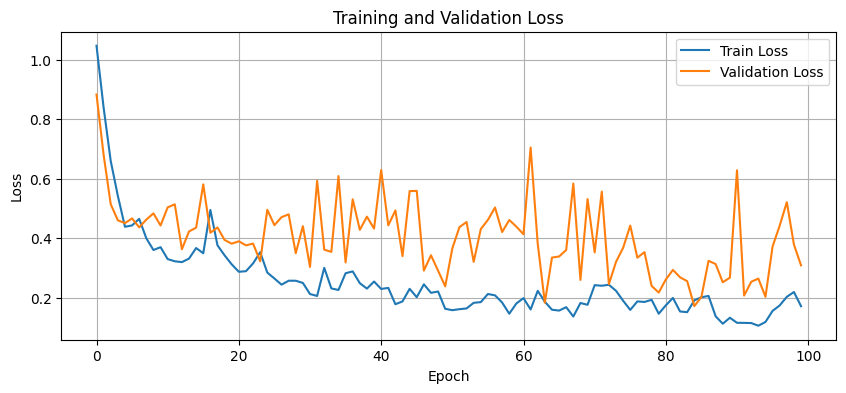

In [20]:
n_epochs = 100

dropout_rate_conv = 0.1
dropout_rate_lin = 0.3

model = CNN_with_dropout(num_classes=3, dropout_rate_conv=dropout_rate_conv, dropout_rate_lin=dropout_rate_lin).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = None

# Train the model without
train_losses, valid_losses, train_accs, valid_accs = train_model(
    model=model, 
    train_loader=train_loader, 
    valid_loader=valid_loader, 
    optimizer=optimizer, 
    lr_scheduler=scheduler, 
    criterion=criterion, 
    n_epochs=n_epochs, 
    device=device
)

## Early stopping

One practical technique to prevent overfitting and save training time is early stopping. It automatically stops training when the model stops improving on the validation set. Instead of training for a fixed number of epochs, we monitor the validation loss and stop training if it doesn't improve for a certain number of epochs (called **patience**). The patience should be set appropriately, too low (2-3) might stop too early, too high (>20) defeats the purpose.

It monitors validation loss after each epoch. Then it track the best validation loss seen so far and counts epochs without improvement (patience counter). It stop training if patience is exceeded and restores best weights from the epoch with lowest validation loss.

### Why Does It Help?

1. **Prevents Overfitting**: Stops training before the model starts memorizing the training data instead of learning general patterns. 

2. **Saves Time**: No need to train for hundreds of epochs if the model stopped improving after 50 epochs.

3. **Automatic**:  You don't have to guess the optimal number of epochs in advance - the algorithm decides for you.

4. **Better Generalization**: Returns the model from the epoch where it performed best on validation data, not the last epoch.

### Key Parameters

- **Patience**: How many epochs to wait without improvement before stopping (typical: 5-15 epochs)
- **Min Delta**: Minimum change in validation loss to count as improvement (typical: 0.001)
- **Restore Best Weights**: Whether to load the best model weights when stopping (usually:  True)


### When to Use Early Stopping

**Use when:**
- Training for many epochs (>30)
- Risk of overfitting
- Don't know optimal number of epochs
- Want to save computational time

**Don't use when:**
- Training for very few epochs (<15)
- Validation loss is very noisy
- Using other strong regularization already


In [21]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def step(self, current_loss):
        if self.best_loss is None or current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.best_weights = model.state_dict().copy()
            self.counter = 0
        else:
            self.counter += 1

        return self.counter >= self.patience

Starting training...
Epoch [1/1000] - Train Loss: 1.0901, Train Acc: 42.22% | Val Loss: 1.0412, Val Acc: 45.83%
Epoch [11/1000] - Train Loss: 0.5277, Train Acc: 75.83% | Val Loss: 0.5648, Val Acc: 70.83%
Epoch [21/1000] - Train Loss: 0.3592, Train Acc: 82.78% | Val Loss: 0.4574, Val Acc: 71.67%
Epoch [31/1000] - Train Loss: 0.3400, Train Acc: 83.06% | Val Loss: 0.4537, Val Acc: 75.00%
Epoch [41/1000] - Train Loss: 0.2709, Train Acc: 86.11% | Val Loss: 0.4542, Val Acc: 74.17%
Early stopping triggered
--------------------------------------------------
Training completed!


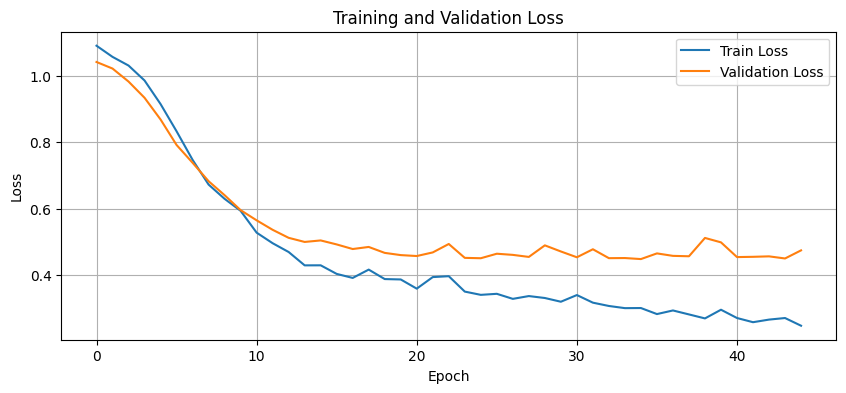

In [22]:
n_epochs = 1000

model = Waveform_Classification_CNN(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0008)
scheduler = None

# Train the model with residual connections
train_losses, valid_losses, train_accs, valid_accs = train_model(
    model=model, 
    train_loader=train_loader, 
    valid_loader=valid_loader, 
    optimizer=optimizer, 
    lr_scheduler=scheduler, 
    criterion=criterion, 
    early_stopping=EarlyStopping(patience=10, min_delta=0.001),
    n_epochs=n_epochs, 
    device=device
)

## Data augmentation

Another way to get better results and prevent overfitting is by augmenting the training data. Data augmentation artificially increases the size and diversity of the training dataset by applying random transformations to existing samples. It is important to **only augment training data**, Never augment validation or test sets! These should represent real-world data to give honest performance metrics. Furthermore, don't distort the data so much that it no longer represents the task.

### Why Use Data Augmentation?

1. **Increases Dataset Size**: Turns limited data into a much larger, more diverse training set
2. **Prevents Overfitting**: Model can't memorize the data when it looks different each time
3. **Improves Robustness**: Helps the model handle noisy or varied real-world data during inference
4. **Better Generalization**: Model learns the underlying patterns rather than specific examples
5. **Acts as Regularization**: Similar to dropout, reduces the gap between training and validation performance

For audio data augmentation the following can be done: 

- Noise injection: add gaussian or random noise to the audio dataset to improve the model performance. 
- Shifting: shift audio left (fast forward) or right with random seconds.
- Changing the speed: stretches times series by a fixed rate.
- Changing the pitch: randomly change the pitch of the audio. 

In [23]:
def augment_waveform(waveform):
    """Apply random augmentations to waveform"""
    augmented = waveform.copy()
    
    # Time shift (50% chance)
    if np.random.random() < 0.5:
        shift = np.random.randint(-10, 10)
        augmented = np.roll(augmented, shift)
    
    # Add noise (70% chance)
    if np.random.random() < 0.7:
        noise = np. random.normal(0, 0.02, len(augmented))
        augmented += noise
    
    # Amplitude scaling (50% chance)
    if np.random.random() < 0.5:
        scale = np.random.uniform(0.8, 1.2)
        augmented *= scale
    
    # Invert (20% chance)
    if np.random.random() < 0.2:
        augmented = -augmented
    
    return augmented

In [24]:
class ExpandedAugmentedDataset(Dataset):
    def __init__(self, X, y, expansion_factor=3, apply_random_aug=True):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(y, dtype=torch.long)
        self.expansion_factor = expansion_factor
        self.apply_random_aug = apply_random_aug
        self.original_size = len(X)
    
    def __len__(self):
        # Dataset is expansion_factor times larger
        return self.original_size * self.expansion_factor
    
    def __getitem__(self, idx):
        # Map to original index
        original_idx = idx % self.original_size
        
        waveform = self.X[original_idx]
        label = self.y[original_idx]
        
        # If not the first copy (idx >= original_size), apply augmentation
        if idx >= self.original_size and self.apply_random_aug:
            wave_np = waveform.squeeze(0).numpy()
            wave_np = augment_waveform(wave_np)
            waveform = torch.tensor(wave_np, dtype=torch.float32).unsqueeze(0)
        
        return waveform, label

# Extract training indices
train_indices = train_dataset.indices
X_train = X[train_indices]
y_train = y[train_indices]

# Create expanded training dataset (3x larger with random augmentation)
train_dataset_expanded = ExpandedAugmentedDataset(
    X_train, y_train, 
    expansion_factor=2,      # 2x larger (original + 1x augmented)
    apply_random_aug=True    # Apply random augmentation
)


# Validation/test unchanged
train_loader_expanded = DataLoader(train_dataset_expanded, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Starting training...
Epoch [1/100] - Train Loss: 1.0798, Train Acc: 40.28% | Val Loss: 1.0422, Val Acc: 40.00%
Epoch [11/100] - Train Loss: 0.4419, Train Acc: 79.17% | Val Loss: 0.5148, Val Acc: 69.17%
Epoch [21/100] - Train Loss: 0.3865, Train Acc: 83.89% | Val Loss: 0.4980, Val Acc: 70.00%
Epoch [31/100] - Train Loss: 0.3178, Train Acc: 82.78% | Val Loss: 0.4760, Val Acc: 75.83%
Epoch [41/100] - Train Loss: 0.2602, Train Acc: 87.78% | Val Loss: 0.5409, Val Acc: 74.17%
Epoch [51/100] - Train Loss: 0.1940, Train Acc: 92.22% | Val Loss: 0.5417, Val Acc: 75.83%
Epoch [61/100] - Train Loss: 0.1369, Train Acc: 95.56% | Val Loss: 0.5985, Val Acc: 76.67%
Epoch [71/100] - Train Loss: 0.1157, Train Acc: 95.56% | Val Loss: 0.5790, Val Acc: 77.50%
Epoch [81/100] - Train Loss: 0.0799, Train Acc: 98.06% | Val Loss: 0.5752, Val Acc: 80.00%
Epoch [91/100] - Train Loss: 0.0658, Train Acc: 98.61% | Val Loss: 0.6443, Val Acc: 80.83%
Epoch [100/100] - Train Loss: 0.0414, Train Acc: 99.44% | Val Loss: 0.

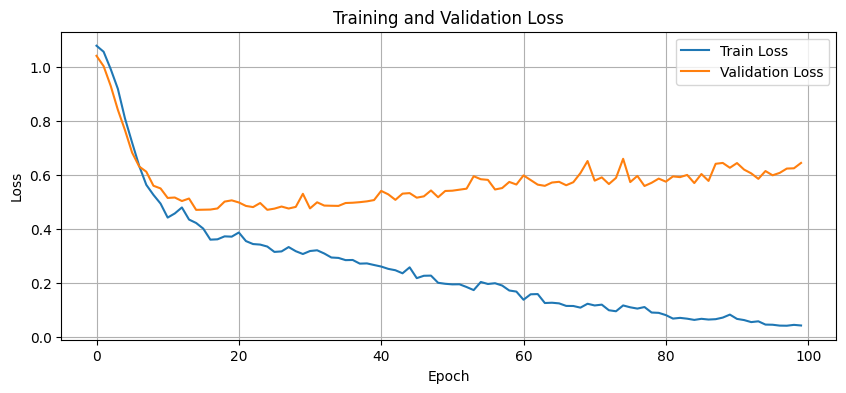

In [25]:
n_epochs = 100

model = Waveform_Classification_CNN(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0008)
scheduler = None

# Train the model with residual connections
train_losses, valid_losses, train_accs, valid_accs = train_model(
    model=model, 
    train_loader= train_loader, 
    valid_loader=valid_loader, 
    optimizer=optimizer, 
    lr_scheduler=scheduler, 
    criterion=criterion, 
    n_epochs=n_epochs, 
    device=device
)

Starting training...
Epoch [1/100] - Train Loss: 1.0624, Train Acc: 34.58% | Val Loss: 0.9906, Val Acc: 45.00%
Epoch [11/100] - Train Loss: 0.3717, Train Acc: 81.67% | Val Loss: 0.4534, Val Acc: 75.00%
Epoch [21/100] - Train Loss: 0.2561, Train Acc: 88.47% | Val Loss: 0.3778, Val Acc: 82.50%
Epoch [31/100] - Train Loss: 0.1867, Train Acc: 92.64% | Val Loss: 0.2209, Val Acc: 89.17%
Epoch [41/100] - Train Loss: 0.0787, Train Acc: 98.19% | Val Loss: 0.1525, Val Acc: 92.50%
Epoch [51/100] - Train Loss: 0.0561, Train Acc: 98.61% | Val Loss: 0.1441, Val Acc: 92.50%
Epoch [61/100] - Train Loss: 0.0360, Train Acc: 99.03% | Val Loss: 0.0926, Val Acc: 95.00%
Epoch [71/100] - Train Loss: 0.0308, Train Acc: 99.31% | Val Loss: 0.0572, Val Acc: 99.17%
Epoch [81/100] - Train Loss: 0.0248, Train Acc: 99.17% | Val Loss: 0.1550, Val Acc: 91.67%
Epoch [91/100] - Train Loss: 0.0169, Train Acc: 99.72% | Val Loss: 0.0385, Val Acc: 99.17%
Epoch [100/100] - Train Loss: 0.0147, Train Acc: 99.72% | Val Loss: 0.

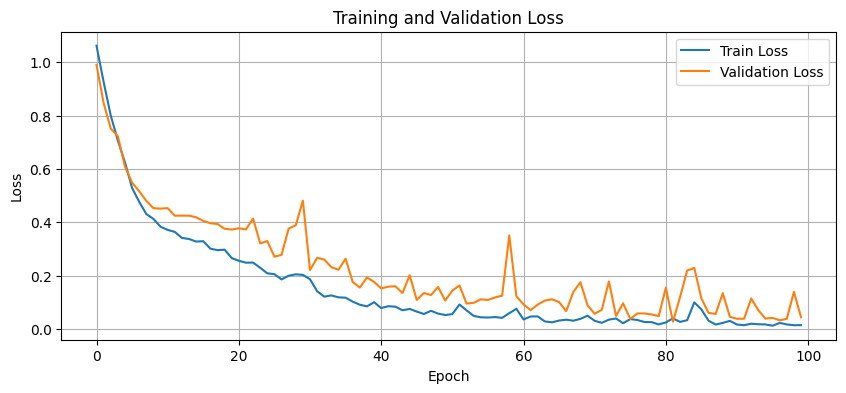

In [26]:
n_epochs = 100

model = Waveform_Classification_CNN(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0008)
scheduler = None

# Train the model with residual connections
train_losses, valid_losses, train_accs, valid_accs = train_model(
    model=model, 
    train_loader= train_loader_expanded, 
    valid_loader=valid_loader, 
    optimizer=optimizer, 
    lr_scheduler=scheduler, 
    criterion=criterion, 
    n_epochs=n_epochs, 
    device=device
)

# Transfer learning

Transfer learning is a powerful technique where a model trained on one task is reused as the starting point for a model on a different but related task. Instead of training a neural network from scratch with randomly initialized weights, we start with weights that have already learned useful features from a large dataset. 

Transfer learning involves taking a pre-trained model (trained on a large dataset like ImageNet with millions of images) and adapting it to your specific task. The key idea is that the features learned on the original task are generalizable and useful for the new task.

**Common workflow:**
1. Start with a model pre-trained on a large dataset (e.g., ResNet trained on ImageNet)
2. Remove the final classification layer(s)
3. Add new layer(s) suited to your task
4. Fine-tune the model on your dataset

### Two Main Approaches

1. **Feature Extraction (Frozen Base)**: Use the pre-trained model as a fixed feature extractor. Freeze the pre-trained layers and only train the new layers you added.

2. **Fine-Tuning**: Unfreeze some or all of the pre-trained layers and train them with a low learning rate, along with the new layers.

### Why Does Transfer Learning Work?

1. **Hierarchical Feature Learning**: Neural networks learn features in a hierarchy: 
   - **Early layers**: Learn general, low-level features (edges, textures, simple patterns)
   - **Middle layers**: Learn mid-level features (shapes, object parts)
   - **Late layers**:  Learn high-level, task-specific features (specific object classes)

2. **Knowledge Transfer**: Features learned on one task (e.g., recognizing cats and dogs) are often useful for related tasks (e.g., recognizing wildlife)

3. **Less Data Required**: Pre-trained models have already learned useful representations, so you need less data to train for your specific task

4. **Faster Training**: Starting from good weights means faster convergence than random initialization




Starting training...
Epoch [1/50] - Train Loss: 1.0430, Train Acc: 37.22% | Val Loss: 0.8071, Val Acc: 57.50%
Epoch [11/50] - Train Loss: 0.3729, Train Acc: 80.28% | Val Loss: 0.5095, Val Acc: 75.00%
Epoch [21/50] - Train Loss: 0.2847, Train Acc: 87.50% | Val Loss: 0.5444, Val Acc: 74.17%
Epoch [31/50] - Train Loss: 0.2868, Train Acc: 88.33% | Val Loss: 0.4358, Val Acc: 80.83%
Epoch [41/50] - Train Loss: 0.1596, Train Acc: 93.89% | Val Loss: 0.3372, Val Acc: 86.67%
Epoch [50/50] - Train Loss: 0.2490, Train Acc: 89.17% | Val Loss: 0.3318, Val Acc: 83.33%
--------------------------------------------------
Training completed!


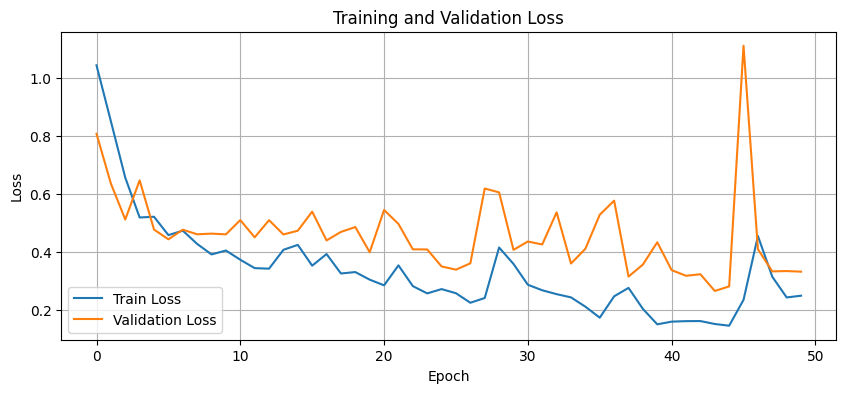


✓ Base model trained and saved!


In [32]:
n_epochs = 50

dropout_rate_conv = 0.1
dropout_rate_lin = 0.3

base_model = CNN_with_dropout(num_classes=3, dropout_rate_conv=dropout_rate_conv, dropout_rate_lin=dropout_rate_lin).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(base_model.parameters(), lr=0.01)
scheduler = None

# Train the model without
train_losses, valid_losses, train_accs, valid_accs = train_model(
    model=base_model, 
    train_loader=train_loader, 
    valid_loader=valid_loader, 
    optimizer=optimizer, 
    lr_scheduler=scheduler, 
    criterion=criterion, 
    n_epochs=n_epochs, 
    device=device
)

# Save the pre-trained model
torch.save(base_model.state_dict(), 'base_model_3_classes.pth')
print("\n✓ Base model trained and saved!")

In [33]:
def generate_sawtooth(length, fs):
    t = np.linspace(0, 1, length, endpoint=False)
    freq = np.random.uniform(1, 10)
    amp = np.random.uniform(0.5, 1.5)
    phi = np.random.uniform(0, 2*np.pi)
    y = amp * signal.sawtooth(2 * np.pi * freq * t + phi, 0)  # width=0 for sawtooth
    noise = np.random.normal(0, 0.05, length)
    return y + noise

def generate_pulse(length, fs):
    t = np.linspace(0, 1, length, endpoint=False)
    freq = np.random. uniform(1, 10)
    amp = np.random.uniform(0.5, 1.5)
    phi = np.random.uniform(0, 2*np.pi)
    y = amp * signal.square(2 * np.pi * freq * t + phi, duty=0.25)  # 25% duty cycle
    noise = np.random.normal(0, 0.05, length)
    return y + noise

def generate_extended_waveform(wave_type, length, fs):
    if wave_type == 'sine':
        return generate_waveform('sine', length, fs)
    elif wave_type == 'triangle':
        return generate_waveform('triangle', length, fs)
    elif wave_type == 'square':
        return generate_waveform('square', length, fs)
    elif wave_type == 'sawtooth': 
        return generate_sawtooth(length, fs)
    elif wave_type == 'pulse': 
        return generate_pulse(length, fs)
    else:
        raise ValueError(f"Unknown wave type: {wave_type}")

# Generate extended dataset (5 classes)
wave_types_extended = ['sine', 'triangle', 'square', 'sawtooth', 'pulse']
X_extended = []
y_extended = []

for idx, wave in enumerate(wave_types_extended):
    for _ in range(200):  # 200 samples per class
        waveform = generate_extended_waveform(wave, length=128, fs=128)
        X_extended.append(waveform)
        y_extended.append(idx)

X_extended = np.array(X_extended)
y_extended = np.array(y_extended)

print(f"\nExtended dataset:  {len(X_extended)} samples, {len(wave_types_extended)} classes")


Extended dataset:  1000 samples, 5 classes


In [34]:
# Prepare extended dataset
dataset_extended = WaveformDataset(X_extended, y_extended)
train_size_ext = int(0.6 * len(dataset_extended))
valid_size_ext = int(0.2 * len(dataset_extended))
test_size_ext = len(dataset_extended) - train_size_ext - valid_size_ext

train_dataset_ext, valid_dataset_ext, test_dataset_ext = random_split(
    dataset_extended, [train_size_ext, valid_size_ext, test_size_ext]
)

train_loader_ext = DataLoader(train_dataset_ext, batch_size=32, shuffle=True)
valid_loader_ext = DataLoader(valid_dataset_ext, batch_size=32)
test_loader_ext = DataLoader(test_dataset_ext, batch_size=32)

In [35]:
class TransferLearningCNN(nn.Module):
    def __init__(self, base_model, num_new_classes=5):
        super().__init__()
        # Copy layers from base model
        self.conv1 = base_model.conv1
        self.conv2 = base_model.conv2
        self.pool = base_model.pool
        self.fc1 = base_model.fc1
        
        # Replace final layer for new number of classes
        self.fc2 = nn.Linear(64, num_new_classes)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x. size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def freeze_feature_layers(self):
        for param in self. conv1.parameters():
            param.requires_grad = False
        for param in self.conv2.parameters():
            param.requires_grad = False
        for param in self.fc1.parameters():
            param.requires_grad = False
    
    def unfreeze_all(self):
        for param in self.parameters():
            param.requires_grad = True

# Load base model and create transfer learning model
base_model_loaded = Waveform_Classification_CNN(num_classes=3).to(device)
base_model_loaded.load_state_dict(torch.load('base_model_3_classes.pth'))

transfer_model = TransferLearningCNN(base_model_loaded, num_new_classes=5).to(device)

Starting training...
Epoch [1/50] - Train Loss: 1.1410, Train Acc: 53.67% | Val Loss: 0.8144, Val Acc: 68.00%
Epoch [11/50] - Train Loss: 0.4355, Train Acc: 79.67% | Val Loss: 0.4591, Val Acc: 74.00%
Epoch [21/50] - Train Loss: 0.3964, Train Acc: 82.00% | Val Loss: 0.4678, Val Acc: 73.50%
Epoch [31/50] - Train Loss: 0.4226, Train Acc: 80.00% | Val Loss: 0.5761, Val Acc: 73.00%
Epoch [41/50] - Train Loss: 0.3710, Train Acc: 82.50% | Val Loss: 0.6297, Val Acc: 76.00%
Epoch [50/50] - Train Loss: 0.3809, Train Acc: 84.00% | Val Loss: 0.4720, Val Acc: 76.00%
--------------------------------------------------
Training completed!


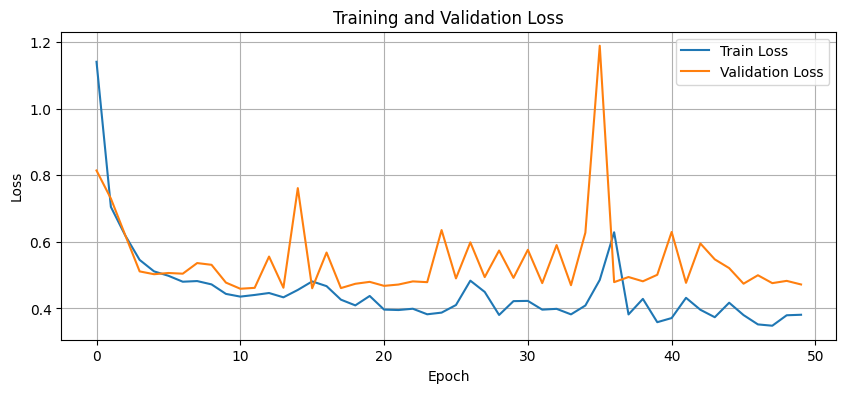

In [36]:
# Freeze feature layers
transfer_model.freeze_feature_layers()

# Train only the new final layer
optimizer_transfer = optim.Adam(filter(lambda p: p.requires_grad, transfer_model.parameters()), lr=0.01)

train_losses_transfer, valid_losses_transfer, _, _ = train_model(
    model=transfer_model,
    train_loader=train_loader_ext,
    valid_loader=valid_loader_ext,
    criterion=criterion,
    optimizer=optimizer_transfer,
    n_epochs=50,
    device=device
)